# Book Recommendation System

## 1. Import Library

In [36]:
import numpy as np
import pandas as pd
from collections import defaultdict
import heapq
from operator import itemgetter
from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, CoClustering, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_colwidth', -1)

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 2. EDA

In [3]:
# There are three dataset contains users, book and rating information.
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
book = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, escapechar='\\', encoding='latin-1')
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')

In [4]:
print('Users: ', users.shape)
print('Book: ', book.shape)
print('Ratings: ', ratings.shape)

Users:  (278858, 3)
Book:  (271379, 8)
Ratings:  (1149780, 3)


In [5]:
display('users.head()', 'ratings.head()', 'book.head(3)')

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3


### User

In [6]:
print('Max. Age: ', users['Age'].max())
print('Min. Age: ', users['Age'].min())

Max. Age:  244.0
Min. Age:  0.0


In [7]:
users.isnull().sum()

User-ID     0     
Location    0     
Age         110762
dtype: int64

### Book

In [8]:
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [9]:
# Since there are only 2 missing values, we'll just drop it.
book.dropna(inplace=True)
book.drop(['Image-URL-S', 'Image-URL-M'], axis=1, inplace=True)
book.columns = ['ISBN', 'title', 'author', 'year', 'publisher', 'image']
book.head()

,ISBN,title,author,year,publisher,image
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [10]:
# There are incorrect Year: '0' and future year.
print(sorted(book['year'].unique()))
print()
print('No. of rows with Year 0: ', book.query('year == 0').shape)
print('No. of rows with future Year: ', book.query('year >= 2020').shape)

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]

No. of rows with Year 0:  (4619, 6)
No. of rows with future Year:  (17, 6)


In [11]:
# For simplicity, rows with incorrect year are replaced with mean.
# Alternatively, use webscrapping to collect and replace with correct year.
book.loc[(book['year'] == 0) | (book['year'] >= 2020)] = np.nan
book['year'] = book['year'].fillna(round(book['year'].mean()))
book['year'] = book['year'].astype(int)

### Rating

In [12]:
ratings.columns = ['user', 'ISBN', 'rating']
ratings.nunique()

user      105283
ISBN      340556
rating    11    
dtype: int64

In [13]:
ratings.isnull().sum()

user      0
ISBN      0
rating    0
dtype: int64

In [14]:
sorted(ratings['rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

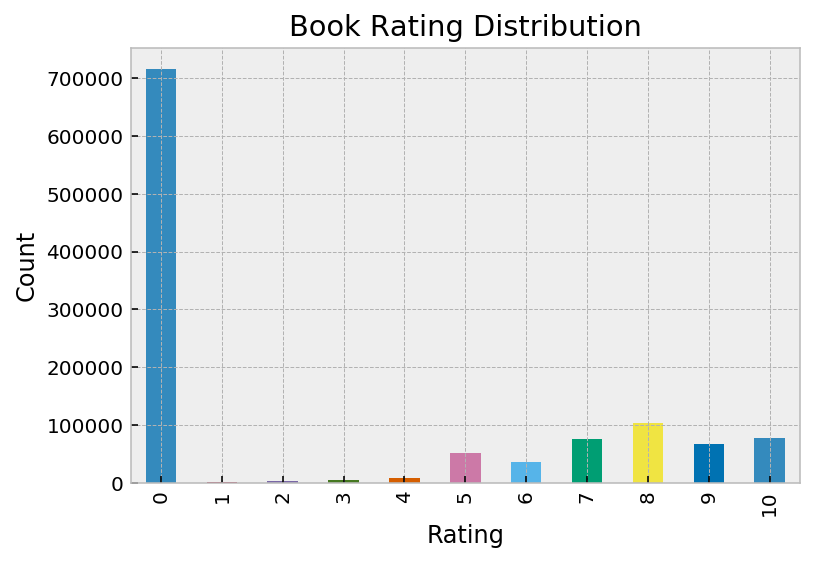

In [15]:
# Majority of the data have 0 rating.
ratings['rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Book Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

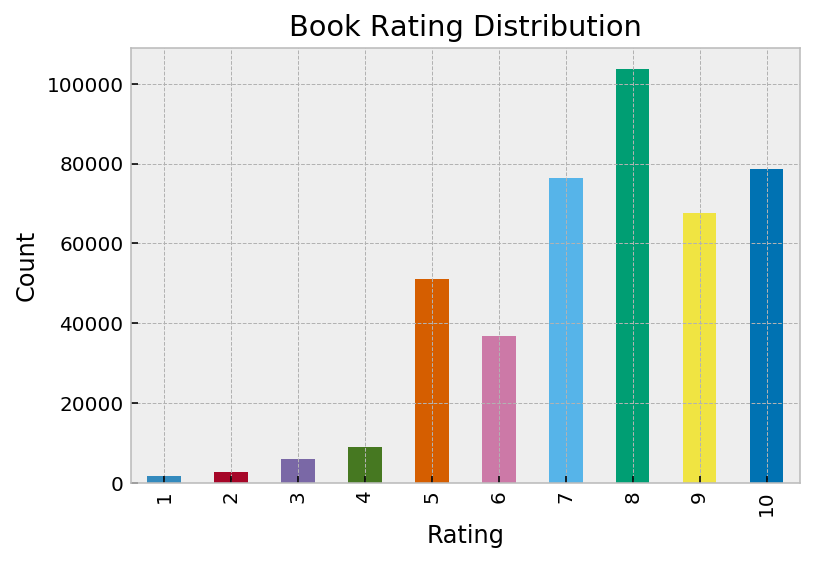

In [16]:
# For book with non-zero rating, majority has rating 8.
ratings['rating'].value_counts(sort=False)[1:].plot(kind='bar')
plt.title('Book Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## 3. Popularity-based Recommendation System

In [17]:
# Join dataset on book number.
df = ratings.merge(book, how='left', on='ISBN')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(1017096, 8)

In [18]:
# Recommend based on number of customer reviews.
top20 = df.groupby('ISBN').count().sort_values(ascending=False, by='rating').head(20).index
print('Top 20 Popular book:')
book.query('ISBN in @top20').drop('image', axis=1)

Top 20 Popular book:


,ISBN,title,author,year,publisher
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far
67,0804106304,The Joy Luck Club,Amy Tan,1994,Prentice Hall (K-12)
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
456,044021145X,The Firm,John Grisham,1992,Bantam Dell Publishing Group
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books


In [19]:
# Recommend based on total rating score.
top20 = df.groupby('ISBN').sum().sort_values(ascending=False, by='rating').head(20).index
print('Top 20 Popular book:')
book.query('ISBN in @top20').drop('image', axis=1)

Top 20 Popular book:


,ISBN,title,author,year,publisher
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far
37,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &amp; Company
90,0316769487,The Catcher in the Rye,J.D. Salinger,1991,"Little, Brown"
107,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion
118,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
305,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA


In [20]:
# Recommend based on mean rating score.
top20 = df.groupby('ISBN').mean().sort_values(ascending=False, by='rating').head(20).index
print('Top 20 Popular book:')
book.query('ISBN in @top20').drop('image', axis=1)

Top 20 Popular book:


,ISBN,title,author,year,publisher
12984,0152013415,Down to Earth,Michael J. Rosen,1998,Harcourt Children's Books
29306,095931833X,Breastfeeding Matters: What We Need to Know About Infant Feeding,Maureen K. Minchin,1998,Alma Publications
72505,0590341723,Everything You Need to Know About Geography Homework (Scholastic Homework Reference Series),Anne Zeman,1997,Scholastic
88185,0152012850,The Sea of Tranquillity,Mark Haddon,1996,Harcourt Children's Books
92810,0953596400,Philos,J.G. Messervy-Norman,1999,Biscuit Tree Books
107319,0152013180,Press-Out Masks to Make and Decorate from Around the World: From Around the World,Vivien Frank,1996,Harcourt
107484,0953494705,Eclipse 1999: the Last Total Eclipse of the Millennium,Antonia Thomas,1999,Planetesimal Publishing Ltd
107639,0953443035,The Box Hill Book of Bats,Frank Greenaway,2001,Friends of Box Hill Association
125274,0152013318,Big Fat Hen,Keith Baker,1997,Red Wagon Books
126326,0953249093,AS Level ICT,P.M. Heathcote,2000,Payne-Gallway Publishers Ltd


## 4. User-based Collaborative Filtering

### Data Sampling

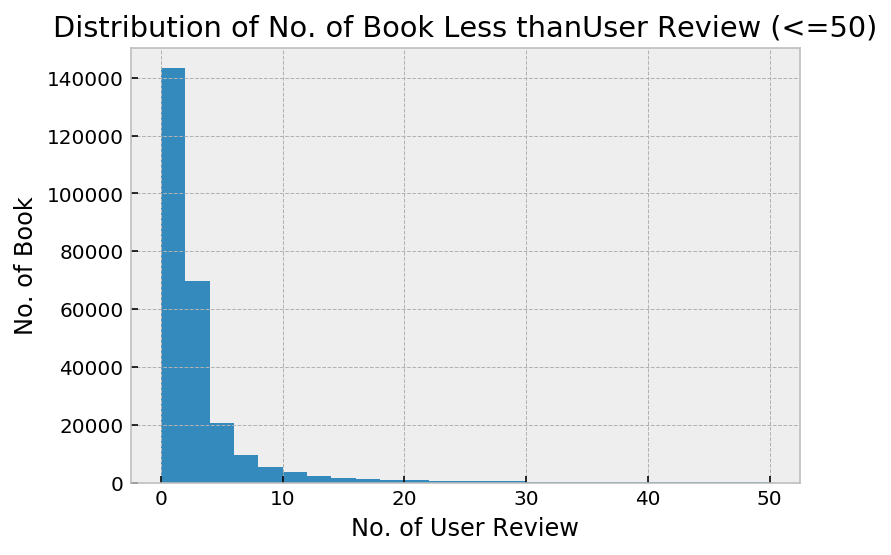

In [21]:
# Majority of book only has less than 10 reviews.
df.groupby('ISBN')['rating'].count().hist(bins=range(0, 51, 2))
plt.title('Distribution of No. of Book Less thanUser Review (<=50)')
plt.xlabel('No. of User Review')
plt.ylabel('No. of Book')
plt.show()

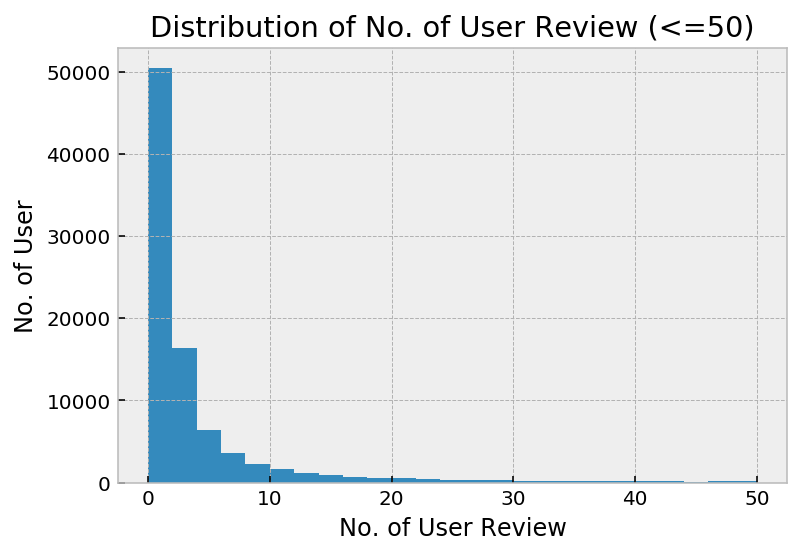

In [22]:
# The distribution is similar for users.
df.groupby('user')['rating'].count().hist(bins=range(0, 51, 2))
plt.title('Distribution of No. of User Review (<=50)')
plt.xlabel('No. of User Review')
plt.ylabel('No. of User')
plt.show()

In [23]:
# We will choose books with more than 50 reviews.
book_rating = df.groupby('ISBN').count()['rating']
user_rating = df.groupby('user').count()['rating']

# We will choose users rated more than 50 book.
isbn = book_rating[book_rating <= 50].index
user_id = user_rating[user_rating <= 50].index

# And we will only use explicit rating (rating > 0) to build the recommender system.
idx = df.query('ISBN in @isbn or rating == 0 or user in @user_id').index
cf = df.drop(idx)
cf.shape

(40196, 8)

In [24]:
cf.nunique()

user         2699
ISBN         2087
rating       10  
title        1901
author       748 
year         38  
publisher    215 
image        2087
dtype: int64

### Model Selection

In [25]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(cf[['user', 'ISBN', 'rating']], reader)

In [26]:
# Compare RMSE for different models.
benchmark = []

sim_options = {'name': 'cosine',
               'user_based': True
               }
algos = [
    KNNBaseline(sim_options=sim_options),
    KNNBasic(sim_options=sim_options),
    KNNWithMeans(sim_options=sim_options),
    KNNWithZScore(sim_options=sim_options)
]

for algo in algos:
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity mat

,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithZScore,1.691267,0.567518,0.412275
KNNWithMeans,1.702771,0.500833,0.412846
KNNBaseline,1.708930,0.540042,0.487292
KNNBasic,1.892031,0.459432,0.381921


### Top N Recommender System

In [27]:
# Build recommendation system using KNNWithZScore.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNWithZScore(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()
print()

# Get top k similar users to our test subject.
testUserInnerID = trainset.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]

similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append((innerID, score))

kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])

# Get the items that similar users rated.
results = defaultdict(list)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainset.ur[innerID]
    for item_inner_id, rating in theirRatings:
        results[item_inner_id].append((userSimilarityScore, rating))

# Predict ratings for each item, weighted by user similarity.
candidates = defaultdict(float)
for item_inner_id, ratings in results.items():
    sim_rating = 0
    sim_sum = 0
    for similarity, rating in ratings:
        sim_rating += similarity * rating
        sim_sum += similarity
    pred_rating = sim_rating / sim_sum
    candidates[item_inner_id] = pred_rating
    
# Build a dictionary of items the user has already read.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items from similar users.
def get_top_n(candidates, testSubject=testSubject, k=10):
    results = {'book_id': [], 'title': [], 'author': [], 'year': []}
    pos = 0

    for itemID, rating in sorted(candidates.items(), key=itemgetter(1), reverse=True):
        if not itemID in read:
            bookID = trainset.to_raw_iid(itemID)
            title = cf[cf['ISBN'] == bookID].title.unique()[0]
            author = cf[cf['ISBN'] == bookID].author.unique()[0]
            year = cf[cf['ISBN'] == bookID].year.unique()[0]

            results['book_id'].append(bookID)
            results['title'].append(title)
            results['author'].append(author)
            results['year'].append(int(year))

            pos += 1
            if (pos == k):
                break

    print('Recommendation for User {}:'.format(testSubject))
    return pd.DataFrame(results)

get_top_n(candidates)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

Recommendation for User 2033:


,book_id,title,author,year
0,0380789035,American Gods,Neil Gaiman,2002
1,0385504209,The Da Vinci Code,Dan Brown,2003
2,0440219078,The Giver (21st Century Reference),LOIS LOWRY,1994
3,0440998050,A Wrinkle in Time,Madeleine L'Engle,1976
4,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994
5,0061097101,The Saving Graces: A Novel,Patricia Gaffney,2000
6,0385484518,"Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson",MITCH ALBOM,1997
7,0440211727,A Time to Kill,JOHN GRISHAM,1992
8,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003
9,0804114609,Patty Jane's House of Curl,Lorna Landvik,1999


### Define Rating Threshold

In [28]:
# Build recommendation system using KNNWithZScore.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'cosine',
               'user_based': True
               }

model = KNNWithZScore(sim_options=sim_options)
model.fit(trainset)

# Build user similarity matrix (N x N).
simsMatrix = model.compute_similarities()
print()

# Get top k similar users to our test subject.
testUserInnerID = trainset.to_inner_uid(testSubject)
similarityRow = simsMatrix[testUserInnerID]

similarUsers = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        similarUsers.append((innerID, score))

# Define similarity threshold.
kNeighbors = []
for rating in similarUsers:
    if rating[1] > 0.95:
        kNeighbors.append(rating)
    
# Get the items that similar users rated.
results = defaultdict(list)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    theirRatings = trainset.ur[innerID]
    for item_inner_id, rating in theirRatings:
        results[item_inner_id].append((userSimilarityScore, rating))

# Predict ratings for each item, weighted by user similarity.
candidates = defaultdict(float)
for item_inner_id, ratings in results.items():
    sim_rating = 0
    sim_sum = 0
    for similarity, rating in ratings:
        sim_rating += similarity * rating
        sim_sum += similarity
    pred_rating = sim_rating / sim_sum
    candidates[item_inner_id] = pred_rating
    
# Build a dictionary of stuff the user has already seen.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items from similar users.
get_top_n(candidates)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.

Recommendation for User 2033:


,book_id,title,author,year
0,0805019375,L Is for Lawless (Kinsey Millhone Mysteries),Sue Grafton,1995
1,0140132708,Midnight's Children,Salman Rushdie,1995
2,034536676X,The World According to Garp,John Irving,1994
3,081297106X,Reading Lolita in Tehran: A Memoir in Books,Azar Nafisi,2003
4,006019491X,Daughter of Fortune : A Novel (Oprah's Book Club (Hardcover)),Isabel Allende,1999
5,0061031410,Courting Trouble,Lisa Scottoline,2003
6,0061099341,As the Crow Flies,Jeffrey Archer,1992
7,0061099708,Colony,Anne Rivers Siddons,1993
8,0312963009,Neanderthal: A Novel,John Darnton,1997
9,0316734837,Fortune's Rocks : A Novel,Anita Shreve,2002


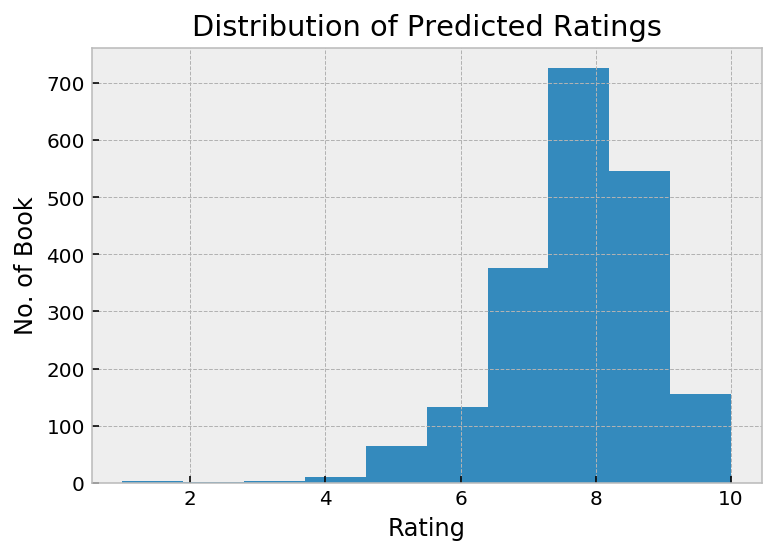

In [29]:
# Check the distribution of predicted ratings.
pd.Series(candidates).hist()
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('No. of Book')
plt.show()

## 5. Item-based Collaborative Filtering

### Model Selection

In [30]:
# Compare RMSE for different models.
benchmark = []

sim_options = {'name': 'pearson',
               'user_based': False
               }
algos = [
    KNNBaseline(sim_options=sim_options),
    KNNBasic(sim_options=sim_options),
    KNNWithMeans(sim_options=sim_options),
    KNNWithZScore(sim_options=sim_options)
]

for algo in algos:
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing si

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,1.650963,0.764681,0.459373
KNNWithMeans,1.746040,0.694767,0.431996
KNNWithZScore,1.755597,0.796502,0.444361
KNNBasic,1.769006,0.675329,0.427461


### Top N Recommender System

In [31]:
# Build recommendation system using KNNBaseline.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'pearson',
               'user_based': False
               }

model = KNNBaseline(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()
print()

testUserInnerID = trainset.to_inner_uid(testSubject)

# Get the top K items we rated.
testUserRatings = trainset.ur[testUserInnerID]
kNeighbors = heapq.nlargest(k, testUserRatings, key=lambda t: t[1])

# Get similar items to stuff we liked (weighted by rating).
candidates = defaultdict(float)
for itemID, rating in kNeighbors:
    similarityRow = simsMatrix[itemID]
    for innerID, similarity in enumerate(similarityRow):
        candidates[innerID] += similarity * rating
    
# Build a dictionary of stuff the user has already seen.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items.
get_top_n(candidates)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Recommendation for User 2033:


,book_id,title,author,year
0,0345339681,The Hobbit : The Enchanting Prelude to The Lord of the Rings,J.R.R. TOLKIEN,1986
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001
2,0684801221,OLD MAN AND THE SEA,Ernest Hemingway,1995
3,0345313860,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986
4,0345339703,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",J.R.R. TOLKIEN,1986
5,1558744630,Chicken Soup for the Teenage Soul (Chicken Soup for the Soul),Jack Canfield,1997
6,0446608815,Pop Goes the Weasel,James Patterson,2000
7,0812511816,"The Eye of the World (The Wheel of Time, Book 1)",Robert Jordan,1990
8,0380002930,Watership Down,Richard Adams,1976
9,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997


### Define Rating Threshold

In [32]:
# Build recommendation system using KNNBaseline.
testSubject = 2033
k = 10

trainset = data.build_full_trainset()

sim_options = {'name': 'pearson',
               'user_based': False
               }

model = KNNBaseline(sim_options=sim_options)
model.fit(trainset)
simsMatrix = model.compute_similarities()
print()

testUserInnerID = trainset.to_inner_uid(testSubject)

# Get the top K items we rated.
testUserRatings = trainset.ur[testUserInnerID]
kNeighbors = []
for rating in testUserRatings:
    if rating[1] > 5.0:
        kNeighbors.append(rating)
        
# Get similar items to stuff we liked (weighted by rating).
candidates = defaultdict(float)
for itemID, rating in kNeighbors:
    similarityRow = simsMatrix[itemID]
    for innerID, score in enumerate(similarityRow):
        candidates[innerID] += score * (rating / 5.0)
    
# Build a dictionary of stuff the user has already seen.
read = {}
for itemID, rating in trainset.ur[testUserInnerID]:
    read[itemID] = 1
    
# Get top-rated items.
get_top_n(candidates)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Recommendation for User 2033:


,book_id,title,author,year
0,0345339681,The Hobbit : The Enchanting Prelude to The Lord of the Rings,J.R.R. TOLKIEN,1986
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001
2,0684801221,OLD MAN AND THE SEA,Ernest Hemingway,1995
3,0345313860,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986
4,0345339703,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",J.R.R. TOLKIEN,1986
5,1558744630,Chicken Soup for the Teenage Soul (Chicken Soup for the Soul),Jack Canfield,1997
6,0425189031,Portrait in Death,Nora Roberts,2003
7,0553213164,Anne of Windy Poplars (Anne of Green Gables Novels (Paperback)),L.M. MONTGOMERY,1983
8,0553280414,A Separate Peace,John Knowles,1985
9,0446608815,Pop Goes the Weasel,James Patterson,2000


## 6. Model-Based Method

### SVD

In [44]:
# Split into trainset and testset.
trainset, testset = train_test_split(data, test_size=0.25)

# Tune the parameters for SVD.
param_grid = {'n_epochs': [10, 20], 'lr_all': [0.01, 0.02],
              'n_factors': [50, 100]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.536424651856614
{'n_epochs': 10, 'lr_all': 0.01, 'n_factors': 50}


In [38]:
# We can now use the algorithm that yields the best rmse.
svd = gs.best_estimator['rmse']
predictions = svd.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.5518


1.5517893820461868

In [40]:
# Let's check some predicted ratings.
results = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'rating', 'pred_rating', 'details'])
results.sample(20)

,user_id,book_id,rating,pred_rating,details
1807,123544,0553273914,6.0,7.970613,{'was_impossible': False}
9367,274308,0812550706,10.0,8.556381,{'was_impossible': False}
2697,235282,0671004530,8.0,7.812890,{'was_impossible': False}
5143,247055,0399149155,7.0,7.748973,{'was_impossible': False}
2113,95173,0060175966,5.0,7.655952,{'was_impossible': False}
9879,223190,0440205573,10.0,8.579182,{'was_impossible': False}
4861,25981,0345441036,10.0,6.439189,{'was_impossible': False}
1933,173481,0440225701,8.0,7.308823,{'was_impossible': False}
2720,99312,0842329269,10.0,8.742022,{'was_impossible': False}
6686,2977,0316569321,7.0,7.092835,{'was_impossible': False}


### SVD++

In [45]:
# Split into trainset and testset.
trainset, testset = train_test_split(data, test_size=0.25)

# Tune the parameters for SVD.
param_grid = {'n_epochs': [10, 20], 'lr_all': [0.005, 0.01],
              'n_factors': [50, 100]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.549299519418356
{'n_epochs': 10, 'lr_all': 0.01, 'n_factors': 50}


In [47]:
# We can now use the algorithm that yields the best rmse.
svdpp = gs.best_estimator['rmse']
predictions = svdpp.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.5278


1.5278378018374847

In [48]:
# Let's check some predicted ratings.
results = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'rating', 'pred_rating', 'details'])
results.sample(20)

,user_id,book_id,rating,pred_rating,details
1261,261603,0812543262,6.0,7.654678,{'was_impossible': False}
5572,35836,0446612545,3.0,5.856832,{'was_impossible': False}
7389,230708,0440236061,9.0,6.798765,{'was_impossible': False}
4838,35859,0446530387,7.0,7.306246,{'was_impossible': False}
1578,27617,0316693200,5.0,8.555112,{'was_impossible': False}
4510,126604,0060392452,8.0,7.100801,{'was_impossible': False}
9806,223190,0553258001,9.0,9.129363,{'was_impossible': False}
7338,151107,0671510053,6.0,7.000079,{'was_impossible': False}
814,61147,0670805149,9.0,8.664773,{'was_impossible': False}
6484,89602,0316666343,8.0,7.256689,{'was_impossible': False}
